In [1]:
import json
import codecs
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, plot_roc_curve
import glob
from os import path
from statistics import mean
import pandas as pd
from matplotlib import pyplot as plt
pd.set_option("display.precision", 2)

## Parameters

In [2]:
results_path = 'results'
best_results_filename = 'best_results.txt'


In [3]:
all_files = glob.glob(f'{results_path}/*/{best_results_filename}')

## Collecting results

In [4]:
all_dev_acc_2 = []
all_dev_acc_3 = []
best_dev_acc_2 = -1
best_model2 = dict()
best_dev_acc_3 = -1
best_model3 = dict()
count = 1
best_count = 1
for filepath in all_files:
    #print(f'File {count}')
    count = count + 1
    with codecs.open(filepath, "r",  'utf-8-sig') as read_file:
        atae_data = json.load(read_file)
        # print(atae_data.keys())
        t = atae_data['acc_train'] 
        d = atae_data['acc_dev']

        all_dev_acc_2.append(d['binary'])
        all_dev_acc_3.append(d['three-way'])
        
        if d['binary'] > best_dev_acc_2:
            best_dev_acc_2 = d["binary"]
            best_model2 = atae_data
            # print(f'binary:{filepath} {d["binary"]}')
        
        if d['three-way'] > best_dev_acc_3:
            best_model3 = atae_data
            best_dev_acc_3 = d['three-way']
            # print(f'3-way:{filepath} {d["three-way"]}')
            best_count = count
        
        test = atae_data['acc_test']
        preds = np.array(atae_data['test']['preds']).argmax(axis = 1)
        targets = np.array(atae_data['test']['solutions']).argmax(axis = 1)
        df = pd.DataFrame({'preds':preds, 'targets':targets})
       # print(df.preds.value_counts())
        # print(df.targets.value_counts())

print(f'mean dev acc binary {mean(all_dev_acc_2)}')
print(f'mean dev acc three-way {mean(all_dev_acc_3)}')
print(f'best acc binary -> {max(all_dev_acc_2)} best acc three-way -> {max(all_dev_acc_3)}')

mean dev acc binary 0.8840039658216239
mean dev acc three-way 0.8269037652212926
best acc binary -> 0.9296482412060302 best acc three-way -> 0.8851674641148325


In [5]:
def calculate_metrics(best_model_results, fig_file_name, roc_title, cm_file_name, cm_title, binary = False, mode = 'test'):
    # print(best_model_results['test']['aspect'])
    preds = np.array(best_model_results[mode]['preds']).argmax(axis = 1)
    pred_raw = best_model_results[mode]['preds']
    targets = np.array(best_model_results[mode]['solutions']).argmax(axis = 1)
    df = pd.DataFrame({'preds':preds, 'pred_raw':pred_raw, 'targets': targets})
    # print(df.preds.value_counts(), df.targets.value_counts())

    if binary:
        df = df[~(df.targets == 1)].copy()
        preds = df.preds.map({0:0, 2:1})
        targets = df.targets.map({0:0, 2:1})
        pred_raw = pd.DataFrame(df.pred_raw.values.tolist()).drop(columns=[1]).values

    rep = pd.DataFrame(classification_report(y_true=targets, y_pred=preds, output_dict=True)).transpose()
    precision,recall,fscore,support = precision_recall_fscore_support(y_true = targets, y_pred = preds)
    cm = confusion_matrix(targets, preds)
    
    import scikitplot as skplt
    skplt.metrics.plot_roc(y_true = targets, y_probas = pred_raw, title = 'ROC: ' + roc_title)
    plt.savefig(f'{mode}_{fig_file_name}', dpi = 300)

    # print(preds)
    skplt.metrics.plot_confusion_matrix(
        y_true = targets,
        y_pred = preds,
        normalize=False,
        title=cm_title,
        figsize=(10, 8),
    )
    plt.savefig(f'{mode}_{cm_file_name}', dpi = 300)

    return rep, precision, recall, fscore, support, cm

## Test Acc for Best BINARY Model

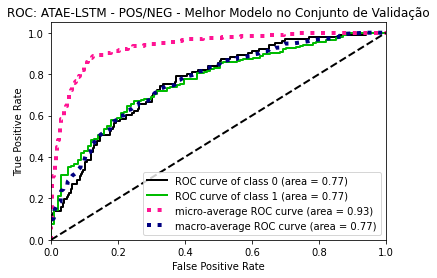

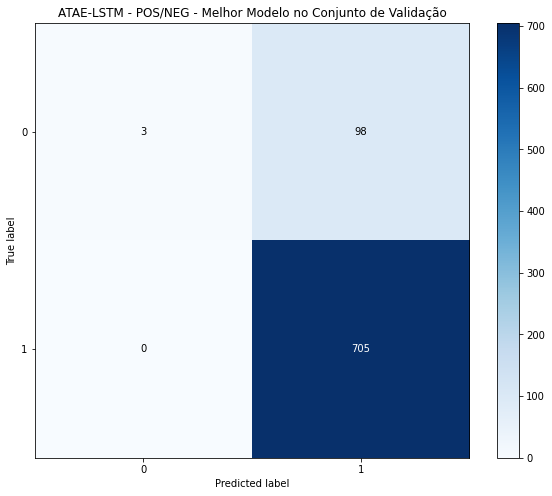

In [6]:
rep, precision, recall, fscore, support, cm = calculate_metrics(best_model2, 
                                                fig_file_name = 'ATAE_LSTM_best_binary_model_roc.pdf', 
                                                roc_title = 'ATAE-LSTM - POS/NEG - Melhor Modelo no Conjunto de Validação',
                                                cm_file_name = 'ATAE_LSTM_best_binary_model_cm.pdf',
                                                cm_title = 'ATAE-LSTM - POS/NEG - Melhor Modelo no Conjunto de Validação',
                                                binary = True,
                                                mode = 'test')

In [7]:
rep

,precision,recall,f1-score,support
0,1.00,0.03,0.06,101.00
1,0.88,1.00,0.94,705.00
accuracy,0.88,0.88,0.88,0.88
macro avg,0.94,0.51,0.50,806.00
weighted avg,0.89,0.88,0.83,806.00


## Test Acc for Best THREE-WAY Model

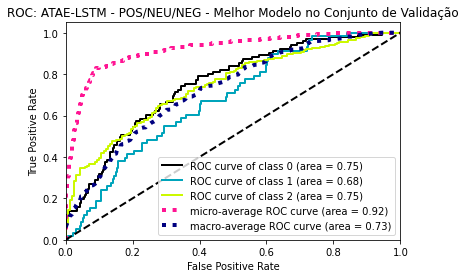

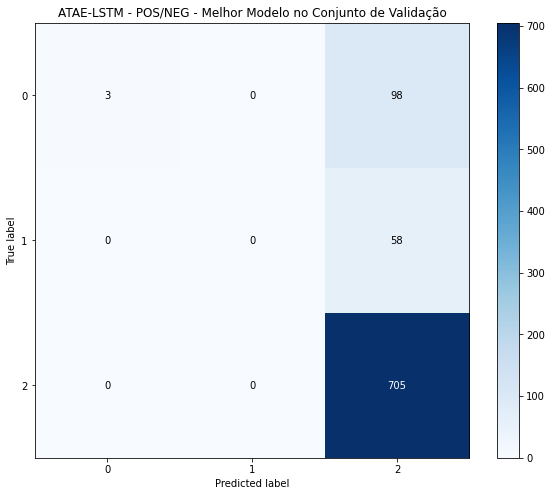

In [8]:
rep3, precision3, recall3, fscore3, support3, cm3 = calculate_metrics(best_model3,
                                                fig_file_name = 'ATAE_LSTM_best_threeway_model_roc.pdf', 
                                                roc_title = 'ATAE-LSTM - POS/NEU/NEG - Melhor Modelo no Conjunto de Validação',
                                                cm_file_name = 'ATAE_LSTM_best_threeway_model_cm.pdf',
                                                cm_title = 'ATAE-LSTM - POS/NEG - Melhor Modelo no Conjunto de Validação', mode = 'test')

In [9]:
rep3

,precision,recall,f1-score,support
0,1.00,0.03,0.06,101.00
1,0.00,0.00,0.00,58.00
2,0.82,1.00,0.90,705.00
accuracy,0.82,0.82,0.82,0.82
macro avg,0.61,0.34,0.32,864.00
weighted avg,0.79,0.82,0.74,864.00


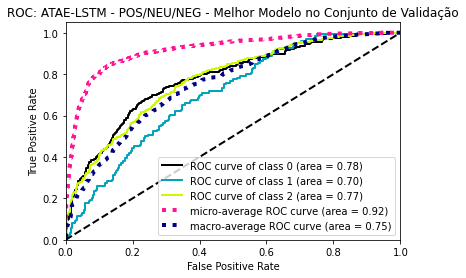

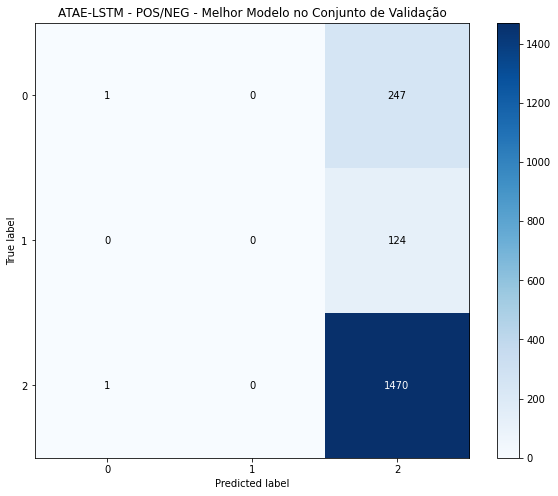

In [10]:
rep3, precision3, recall3, fscore3, support3, cm3 = calculate_metrics(best_model3,
                                                fig_file_name = 'ATAE_LSTM_best_threeway_model_roc.pdf', 
                                                roc_title = 'ATAE-LSTM - POS/NEU/NEG - Melhor Modelo no Conjunto de Validação',
                                                cm_file_name = 'ATAE_LSTM_best_threeway_model_cm.pdf',
                                                cm_title = 'ATAE-LSTM - POS/NEG - Melhor Modelo no Conjunto de Validação', mode = 'train')

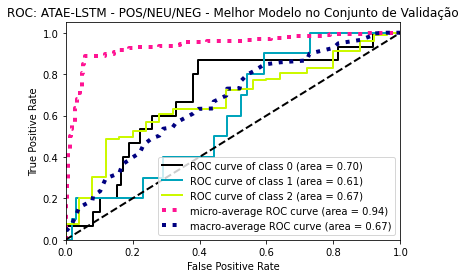

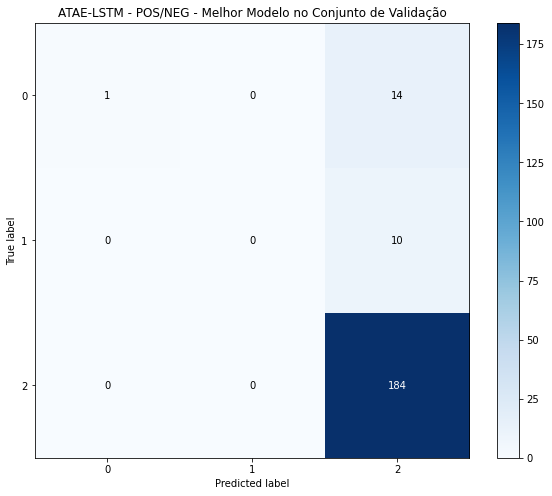

In [11]:
rep3, precision3, recall3, fscore3, support3, cm3 = calculate_metrics(best_model3,
                                                fig_file_name = 'ATAE_LSTM_best_threeway_model_roc.pdf', 
                                                roc_title = 'ATAE-LSTM - POS/NEU/NEG - Melhor Modelo no Conjunto de Validação',
                                                cm_file_name = 'ATAE_LSTM_best_threeway_model_cm.pdf',
                                                cm_title = 'ATAE-LSTM - POS/NEG - Melhor Modelo no Conjunto de Validação', mode = 'dev')